# Speaker Verification Using Adapted Gaussain Mixture Models

Se empleo Maximum A-Posterior (MAP) adaptation, para crear un modelo por cada speaker, usando un UBM previamente entrenado.


# Paper base
Se tomo como base el siguiente articulo para realizar la adaptación
[Speaker Verification Using Adapted Gaussian Mixture Models
](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.117.338&rep=rep1&type=pdf)


In [1]:
from sklearn.mixture import GaussianMixture
import pylab as pl
from scipy import linalg
import numpy as np
import matplotlib as mpl
from joblib import dump, load
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# MAP ADAPTATION

Solo adaptamos el vector de medias

In [0]:

def map_adaptation(gmm,data,max_iterations=300,likelihood_threshold= 1e-20, relevance_factor = 16):
    T = data.shape[0] #Número de ventanas
    D = data.shape[1]  # Dimensiones (Número de coeficientes MFCCS)
    M = gmm.n_components #Número de componentes
    
    #Parametros del UBM
    mu_k = gmm.means_
    cov_k = gmm.covariances_
    pi_k = gmm.weights_
    
    #Inicializamos los parametros del nuevo modelo, los cuales se actualizarán usando el Algoritmo de EM
    mu_new = np.zeros((M,D)) #Vector de medias (300,20) # cada compoenente tiene un vector de medias (1,20)
    cov_new = np.ones((M,D))#Matriz de covarianza
    weights_new = np.zeros((M,1))#Vector de pesos
    
    #Variables auxiliares
    n_i = np.zeros((T,M)) #Vector de probabilidades por compoenentes (300,1) probabilidad de cada componente
    
    #Probabilidades
    # Estas son usadas como condiciona de parada de la adaptación
    old_likelihood = gmm.score(data)
    new_likelihood = 0 # Ya que no se ha creado el modelo nuevo(Adaptado)
    iterations = 0
    # likelihood ratios (LLR) 
    while(abs(old_likelihood - new_likelihood) > likelihood_threshold and iterations < max_iterations):
        iterations +=1
        old_likelihood = new_likelihood # Actualizamos la probabilidad antigua, que va ser 
        
    #1 Paso: first determine the probabilistic alignment of the training vectors into the UBM mixture components
        
        z_n_k = gmm.predict_proba(data) # (T,300) probabilidad de que un vector pertenezca a la componente M.
        n_i = np.sum(z_n_k,axis=0)   # Suma de las probabilidades (300,1) de todos los tiempos en las componentes
        
    #2 Paso: Use Pr(i | x t ) and x t to compute the sufficient statistics for the weight, mean, and variance parameters  
              
        
        for i in range(M): # Por cada componente
            Ei = np.zeros((1,D))
            for t in range(T): #Por cada vector t=0 ,.... T=N_Windows
                xt=data[t,:]
                Ei =Ei+ np.dot(z_n_k[t][i],xt)
            #Normalizamos, dividiendo por n_i
            mu_new[i]=(1/n_i[i])*Ei
        #Calculamos el coeficiente de adaptación 
        adaptation_coefficient = n_i/(n_i+relevance_factor)
    
    #3 Paso: Calculo el nuevo valor de los parametros usando el coeficiente de adaptación
        for i in range(M):
            #Actualizo vector de medias
            mu_k[i] = (adaptation_coefficient[i]*mu_new[i])+((1-adaptation_coefficient[i])*mu_k[i])
            
    #4 Paso: actualizo parametros del modelo a retorna
        gmm.means_=mu_k
        
        
    
    #5 Paso: calculo las nuevas probabilidades del modelo
        log_likelihood = gmm.score(data)
        
        new_likelihood = log_likelihood
        print(log_likelihood)
    return gmm

# Data - Train

Se extraen los MFCCS de 5 audios de una duración promedio de 7 segundo.
- Angelower p225 
- Carlos p226
- Gabriel p227
- Jose p228
- Juan p229
- Leon p230

Descargamos audios procesados y el modelo

In [2]:
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p225.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p226.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p227.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p228.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p229.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p230.hd5


--2020-05-03 14:23:19--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Train/p225.hd5
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Train/p225.hd5 [following]
--2020-05-03 14:23:19--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Train/p225.hd5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254064 (248K) [application/octet-stream]
Saving to: ‘p225.hd5’

p225.hd5            100%[===

In [0]:
PATH_MFCS ='.'
speakers = [225,226,227,228,229,230]
audios_jose = pd.read_hdf(PATH_MFCS+'/p'+'228'+'.hd5').values
audios_leo = pd.read_hdf(PATH_MFCS+'/p'+'230'+'.hd5').values
audios_angelower = pd.read_hdf(PATH_MFCS+'/p'+'225'+'.hd5').values
audios_gabriel = pd.read_hdf(PATH_MFCS+'/p'+'227'+'.hd5').values
audios_juan=pd.read_hdf(PATH_MFCS+'/p'+'229'+'.hd5').values
audios_carlos= pd.read_hdf(PATH_MFCS+'/p'+'226'+'.hd5').values

In [5]:
audios_jose.shape

(2588, 20)

In [6]:
audios_jose

array([[-2.7393596 , -2.5081096 , -0.44896305, ...,  0.7683952 ,
         1.9994147 ,  0.5807953 ],
       [-2.7393596 , -2.5081096 , -0.44896305, ...,  0.7683952 ,
         1.9994147 ,  0.5807953 ],
       [-2.7393596 , -2.5081096 , -0.44896305, ...,  0.7683952 ,
         1.9994147 ,  0.5807953 ],
       ...,
       [-1.7533679 , -0.6422811 ,  0.39061013, ...,  0.9090461 ,
         2.3826962 ,  0.24748895],
       [-2.7354023 , -2.1605017 , -0.02764809, ...,  0.6675646 ,
         1.8938946 ,  0.44412825],
       [-2.887313  , -2.508196  , -0.44910568, ...,  0.7679374 ,
         1.9990138 ,  0.5803384 ]], dtype=float32)

## **Download UBM Model**

In [7]:
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/GMM_300_NC.joblib

--2020-05-03 14:24:52--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/GMM_300_NC.joblib
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/GMM_300_NC.joblib [following]
--2020-05-03 14:24:53--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/GMM_300_NC.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195363 (191K) [application/octet-stream]
Saving to: ‘GMM_300_NC.joblib’

GMM_300_NC.joblib   100%[===

# **Load UBM Model**
GMM de 300 componentes, entrado con 20 speakers, cada uno con un promedio de 350 audios.

In [8]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
gmm_UBM

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=15,
                means_init=None, n_components=300, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=1, verbose_interval=1, warm_start=False,
                weights_init=None)

In [10]:
gmm_UBM.weights_.shape

(300,)

In [11]:
gmm_UBM.means_.shape

(300, 20)

In [12]:
gmm_UBM.covariances_.shape

(300, 20)

# Adaptation of Speaker Model

Bayesian learning or maximum a posteriori (MAP) estimation




**NOTA:** Cada vez que se ejecute la función ***map_adaptation***, se debe cargar nuevamente el UBM, es decir ejecutar la siguiente linea de código

```
gmm_UBM = load('GMM_300_NC.joblib')

```



## Juan ADAPTATION

In [0]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
gmm_juan = map_adaptation(gmm_UBM,audios_juan)

-21.746138562293318
-19.886523703460995
-19.064523291423864
-18.672829414972213
-18.423923114593514
-18.236588331658016
-18.095272591386404
-17.985907242325045
-17.882880538976863
-17.74041587971368
-17.57040836809307
-17.42887672379994
-17.331650090691078
-17.259767516657814
-17.204351139357474
-17.15870527736514
-17.119402356738494
-17.085339013913387
-17.05536836184625
-17.029420816065468
-17.00673491304727
-16.985315023198236
-16.964248206448183
-16.943206886024246
-16.92236322554037
-16.904649186551215
-16.890034452002016
-16.877136588524856
-16.865145744661763
-16.85348330213672
-16.84208630870945
-16.83136331352349
-16.822176117004098
-16.81447173800093
-16.807508606025465
-16.801032193336635
-16.794985599458734
-16.789263039426523
-16.783615580735912
-16.77767909450113
-16.77148665494679
-16.765197487362418
-16.758615822928174
-16.751596696542617
-16.74392055344813
-16.735660732918287
-16.726697190080074
-16.716227632288348
-16.703094661264775
-16.68666694505031
-16.66330628486

In [0]:
name_model = 'GMM_Juan'
dump(gmm_juan, name_model+'.joblib')

['GMM_Juan.joblib']

## Jose ADAPTATION

In [0]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
gmm_jose = map_adaptation(gmm_UBM,audios_jose)

-26.723794640578415
-25.421786014137027
-24.69786030983258
-24.233408758182176
-23.886423164451898
-23.61354416991685
-23.41905639321985
-23.272081571264067
-23.1519011711468
-23.05498313015803
-22.973632283566968
-22.90420714058376
-22.841842366201718
-22.782361151267555
-22.722760811473304
-22.65943883419617
-22.59364892759307
-22.527461878704322
-22.459107392730978
-22.385642265592853
-22.31866081031613
-22.264177042285187
-22.213747123269226
-22.169833249502254
-22.134591437873727
-22.1061393695364
-22.083064024092145
-22.063215961473595
-22.04536225616591
-22.030362454957892
-22.018214949655096
-22.007766836527562
-21.997825177718408
-21.987784556611864
-21.97729851926823
-21.966436223940487
-21.955243615538794
-21.94381800096719
-21.933039409689464
-21.92367725938591
-21.91572175465232
-21.908318042807455
-21.900577571115
-21.89204192702105
-21.882446005246937
-21.871932000678477
-21.86119298644911
-21.85037113063924
-21.83963791960399
-21.829414864704283
-21.819436165330742
-21.

Vemos que los valores de la media cambiarón, los pesos y la matriz de covanrianza se mantienen.

In [0]:
gmm_jose.means_

array([[-0.47405847,  0.77795709,  0.74176243, ...,  0.68262007,
         0.07991054, -1.06929745],
       [-1.12090623, -0.78104588,  0.47939125, ...,  0.52273544,
         0.62146064,  0.36452482],
       [ 1.27123642,  0.71671819, -0.97022947, ..., -0.73384267,
        -0.30346384, -1.15096092],
       ...,
       [ 0.50018052, -1.99246845,  1.39595043, ...,  0.64992682,
        -0.66940025,  1.19049362],
       [-1.51850986, -0.4170364 ,  0.56918476, ..., -0.39044059,
         1.22237722,  0.11280448],
       [ 0.35111886,  0.06563008, -0.28248564, ..., -0.56519293,
        -0.05006237,  0.61350669]])

In [0]:
name_model = 'GMM_Jose'
dump(gmm_jose, name_model+'.joblib')

['GMM_Jose.joblib']

In [0]:
gmm_jose.predict_proba(audios_jose)

array([[1.78788912e-064, 0.00000000e+000, 2.33910946e-092, ...,
        1.47997993e-040, 2.61683220e-077, 9.13485698e-039],
       [1.78788912e-064, 0.00000000e+000, 2.33910946e-092, ...,
        1.47997993e-040, 2.61683220e-077, 9.13485698e-039],
       [1.78788912e-064, 0.00000000e+000, 2.33910946e-092, ...,
        1.47997993e-040, 2.61683220e-077, 9.13485698e-039],
       ...,
       [3.32778360e-016, 2.14258920e-258, 4.06926416e-045, ...,
        1.43574120e-029, 3.20366720e-002, 3.25246732e-015],
       [8.66073089e-057, 0.00000000e+000, 6.75555388e-087, ...,
        2.40742003e-038, 1.38411487e-060, 5.09360111e-035],
       [6.54289615e-068, 0.00000000e+000, 3.08642117e-096, ...,
        9.52294755e-043, 2.37014066e-085, 2.84737841e-040]])

## Angelower ADAPTATION

In [0]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
gmm_angelower = map_adaptation(gmm_UBM,audios_angelower)

-26.23344308670775
-24.964880778549723
-24.344764093526507
-23.971807396208884
-23.711471990150613
-23.49971631334793
-23.319008769388688
-23.16119309171978
-23.023718305051805
-22.904539818614428
-22.81183303666401
-22.73810554014443
-22.6734359545621
-22.613768204926636
-22.55927348685028
-22.510167523449404
-22.468484523672036
-22.43337041956572
-22.40127424140846
-22.37060198744756
-22.34093859473256
-22.31430647718704
-22.291667666610643
-22.27167761102075
-22.2533273339723
-22.23612943622218
-22.21935005643698
-22.202714970613762
-22.18633314067866
-22.1698683165386
-22.15279306309835
-22.135253862623255
-22.118913596502257
-22.104239006859636
-22.090482355872883
-22.07815683176139
-22.067418761420168
-22.057698414950135
-22.048354206798415
-22.03866421311546
-22.027650237112276
-22.014865021546655
-22.001699637822494
-21.98935187221075
-21.977384925268584
-21.9655700149313
-21.954887930540956
-21.945139084290286
-21.935313186759938
-21.925051703522122
-21.91464059825985
-21.9044

In [0]:
name_model = 'GMM_Angelower'
dump(gmm_angelower, name_model+'.joblib')

['GMM_Angelower.joblib']

## Leo ADAPTATION

In [0]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
gmm_leo = map_adaptation(gmm_UBM,audios_leo)

-24.355513906179723
-22.8197789370562
-22.127893963127786
-21.706845225684045
-21.39076477142423
-21.110097310110504
-20.906048907300757
-20.765586967739317
-20.659007445673705
-20.571555323442972
-20.496956917251442
-20.431377164040228
-20.37262172043008
-20.32235821766931
-20.27733308120029
-20.232909842051132
-20.189151981843853
-20.14581889114746
-20.10116233130701
-20.057139834541548
-20.013543312237775
-19.96980186323137
-19.93008712837779
-19.88897585547337
-19.8528148323698
-19.82351418435109
-19.798051070511587
-19.77635369724721
-19.758759163553382
-19.744208812635648
-19.73149530983396
-19.7198285529856
-19.70838954016068
-19.697408110936017
-19.687236512511014
-19.677672715534975
-19.66845502261996
-19.65996339512649
-19.651819974556773
-19.643346882721364
-19.634823739465777
-19.626988522045437
-19.620460276380935
-19.61488824693858
-19.610017950935227
-19.605587114886195
-19.6012020723455
-19.596641968419622
-19.591829730615512
-19.586659973488914
-19.581389897076214
-19.

In [0]:
name_model = 'GMM_Leo'
dump(gmm_leo, name_model+'.joblib')

['GMM_Leo.joblib']

## Carlos ADAPTATION

In [0]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
gmm_carlos = map_adaptation(gmm_UBM,audios_carlos)

-26.432114664712305
-25.23898979640401
-24.58540038813077
-24.179547996927337
-23.889933355810044
-23.66970361204602
-23.49543500650295
-23.353845314798154
-23.233879450121677
-23.131709818066817
-23.045451795424473
-22.97350089969257
-22.91238136318932
-22.857806225012258
-22.808518024066185
-22.764402365336256
-22.723759813526932
-22.685248280218254
-22.64893652767737
-22.61578286117555
-22.58588577221078
-22.558401523085738
-22.533409193735462
-22.51108650486932
-22.490846478046198
-22.47161767004269
-22.452211202119873
-22.432530649100087
-22.413061375680858
-22.393960349010648
-22.376312117581527
-22.36065154291886
-22.34629701939242
-22.332490873035297
-22.319156014050506
-22.306522480307358
-22.29408511370939
-22.28152917197277
-22.26924650433046
-22.257673060818117
-22.246732991479924
-22.236379083540104
-22.226557467327027
-22.2171690331513
-22.207921088624328
-22.198690579159862
-22.18923975656533
-22.17942172106404
-22.16928260154821
-22.159456305475484
-22.150987536416466
-

In [0]:
name_model = 'GMM_Carlos'
dump(gmm_carlos, name_model+'.joblib')

['GMM_Carlos.joblib']

## Gabriel ADAPTATION

In [0]:
gmm_UBM = load('GMM_300_NC.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
gmm_gabriel = map_adaptation(gmm_UBM,audios_gabriel)

-25.350192282713
-24.14859343473505
-23.535477109234794
-23.135556007555138
-22.84442683054503
-22.628728470742455
-22.468442673638936
-22.345686469776236
-22.246678175173138
-22.160486478300925
-22.07734917567208
-21.995677862728456
-21.92381737435374
-21.86367596063844
-21.809926010071273
-21.758924778551552
-21.71538675695911
-21.681117034521147
-21.65344427914715
-21.629176887146656
-21.606581017957392
-21.585879094366895
-21.566637243502967
-21.548105394728005
-21.529861203035292
-21.51247008837487
-21.495969223044767
-21.47959969312719
-21.4625369828702
-21.44643729851482
-21.433330457568427
-21.42135689716439
-21.40954963906453
-21.39835176488001
-21.3883957311166
-21.37940167880516
-21.370813838408388
-21.362852568840033
-21.355798897696914
-21.349514095720327
-21.343562332005817
-21.33747052216825
-21.33066700867259
-21.322608847399398
-21.31358712992318
-21.304441195104125
-21.29654423211487
-21.290520040158135
-21.285686336731704
-21.281589065710392
-21.278084674461446
-21.2

In [0]:
name_model = 'GMM_Gabriel'
dump(gmm_gabriel, name_model+'.joblib')

['GMM_Gabriel.joblib']

# Modelos adaptados

In [13]:
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Angelower.joblib
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Carlos.joblib
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Gabriel.joblib
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Jose.joblib
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Juan.joblib
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Leo.joblib

--2020-05-03 14:25:22--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Angelower.joblib
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Angelower.joblib [following]
--2020-05-03 14:25:22--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/Adaptions_Models/GMM_Angelower.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195413 (191K) [application/octet-stream]


## Test Data

# Cargamos modelos

In [0]:
GMM_Angelower = load('GMM_Angelower.joblib')
GMM_Carlos= load('GMM_Carlos.joblib')
GMM_Gabriel= load('GMM_Gabriel.joblib')
GMM_Jose= load('GMM_Jose.joblib')
GMM_Juan= load('GMM_Juan.joblib')
GMM_Leo= load('GMM_Leo.joblib')

# Distance


In [0]:
def distances_by_sound(speakers_models,sounds,sound_same='Sound_1'):
    
    n_Speakers= len(speakers_models)
    distances = np.ones((n_Speakers,n_Speakers),dtype=np.float64)
    names = []        
    for i in range(n_Speakers): 
      gmm1 = speakers_models[i][1]
      sound1= sounds[i]
      names.append(speakers_models[i][0])
      for j in range(n_Speakers):
        gmm2 = speakers_models[j][1]
        sound2= sounds[j]
        D = distance_probabilities(gmm1,gmm2,sound1,sound2)
        distances[i][j]=D

    return pd.DataFrame(distances, columns=names, index=names)

In [0]:
def distances_by_All_Sounds(speakers_models,sounds,sound_same='All'):
    
    n_Speakers= len(speakers_models)
    distances = np.ones((n_Speakers,n_Speakers),dtype=np.float64)
    names = []        
    for i in range(n_Speakers): 
      gmm1 = speakers_models[i][1]
      sound1= sounds[i]
      names.append(speakers_models[i][0])
      for j in range(n_Speakers):
        gmm2 = speakers_models[j][1]
        sound2= sounds[j]
        D = distance_probabilities(gmm1,gmm2,sound1,sound2)
        distances[i][j]=D

    return pd.DataFrame(distances, columns=names, index=names)

In [0]:
def distance_probabilities(gmm1,gmm2,sound1,sound2):
    nv1 = sound1.shape[0]
    nv2 = sound2.shape[0]
    
    
    score_gmm1_with_sound1 =gmm1.score(sound1) 
    score_gmm2_with_sound1 =gmm2.score(sound1)
    
        
    
    #print('SCORES SOUND 1',score_gmm1_with_sound1,score_gmm2_with_sound1)
    
    score_gmm1_with_sound2 = gmm1.score(sound2)
    score_gmm2_with_sound2 = gmm2.score(sound2)
    
    #print('SCORES SOUND 2',score_gmm1_with_sound2,score_gmm2_with_sound2)
    
    #Remover (1/nv2)
    
    D12= (score_gmm2_with_sound2 - score_gmm1_with_sound2)
    D21 = (score_gmm2_with_sound1 - score_gmm1_with_sound1)
    
    D=(np.absolute(D12 - D21))/2
    return D

In [0]:
speakers_models = [('Angelower',GMM_Angelower),('Carlos',GMM_Carlos),('Gabriel',GMM_Gabriel),('Jose',GMM_Jose),('Juan',GMM_Juan),('Leo',GMM_Leo)]

In [0]:
def createConfusion_matrix(sound_name):
    audios_jose= pd.read_hdf('p228.hd5').values 
    audios_leo= pd.read_hdf('p230.hd5').values
    audios_angelower= pd.read_hdf('p225.hd5').values
    audios_juan= pd.read_hdf('p229.hd5').values
    audios_carlos= pd.read_hdf('p226.hd5').values
    audios_gabriel= pd.read_hdf('p227.hd5').values
    sounds = [audios_angelower,audios_carlos,audios_gabriel,audios_jose,audios_juan,audios_leo]
    df_distances = distances_by_sound(speakers_models,sounds,sound_same='Sound_1')
    confusion_matrix = df_distances.values
    class_names = df_distances.columns 
    print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=12,sound_name=sound_name)

## Sound_1

In [0]:
#Sound 1
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p225.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p226.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p227.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p228.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p229.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p230.hd5


--2020-04-26 02:05:26--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p225.hd5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p225.hd5 [following]
--2020-04-26 02:05:26--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_1/p225.hd5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50448 (49K) [application/octet-stream]
Saving to: ‘p225.hd5’

p225.hd5 

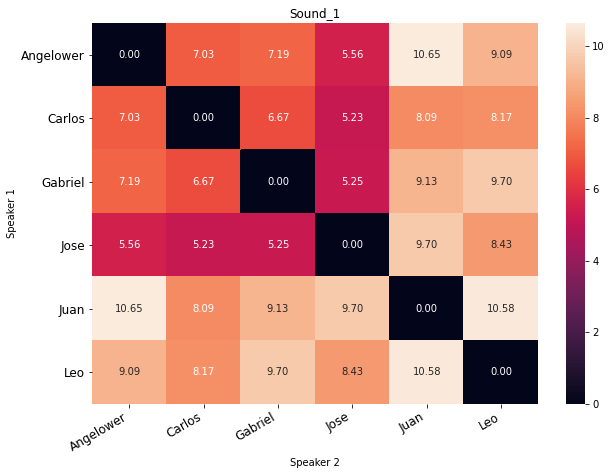

In [0]:
createConfusion_matrix(sound_name='Sound_1')

## Sound_2

In [0]:
#Sound 2
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p225.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p226.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p227.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p228.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p229.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p230.hd5


--2020-04-26 02:05:56--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p225.hd5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p225.hd5 [following]
--2020-04-26 02:05:57--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_2/p225.hd5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59952 (59K) [application/octet-stream]
Saving to: ‘p225.hd5’

p225.

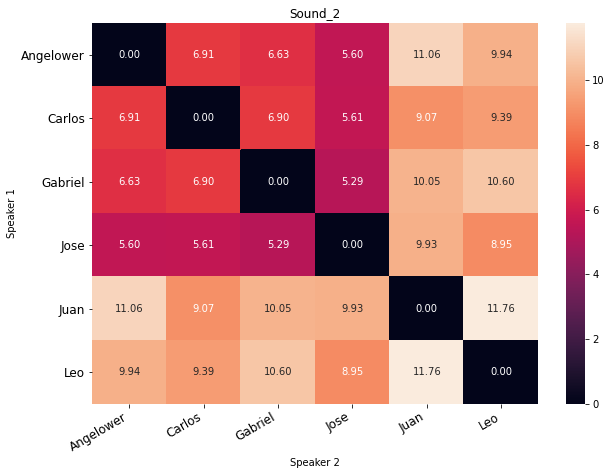

In [0]:
createConfusion_matrix(sound_name='Sound_2')

## Sound_3

In [0]:
#Sound 3
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p225.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p226.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p227.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p228.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p229.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p230.hd5


--2020-04-26 02:06:42--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p225.hd5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p225.hd5 [following]
--2020-04-26 02:06:42--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_3/p225.hd5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49480 (48K) [application/octet-stream]
Saving to: ‘p225.hd5’

p225.hd5 

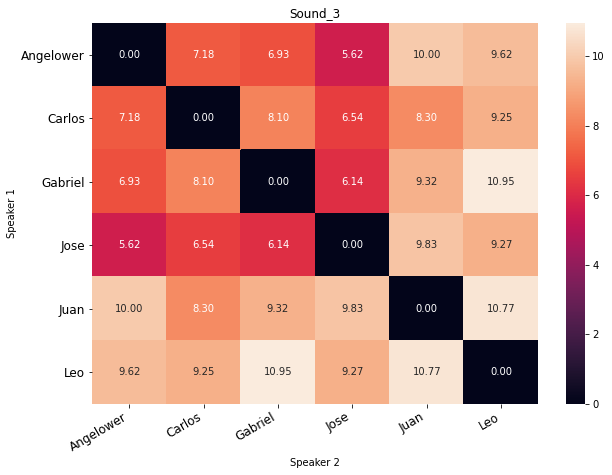

In [0]:
createConfusion_matrix(sound_name='Sound_3')

## Sound_4

In [0]:
#Sound 4
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p225.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p226.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p227.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p228.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p229.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p230.hd5


--2020-04-26 02:07:22--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p225.hd5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p225.hd5 [following]
--2020-04-26 02:07:22--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_4/p225.hd5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64704 (63K) [application/octet-stream]
Saving to: ‘p225.hd5’

p225.

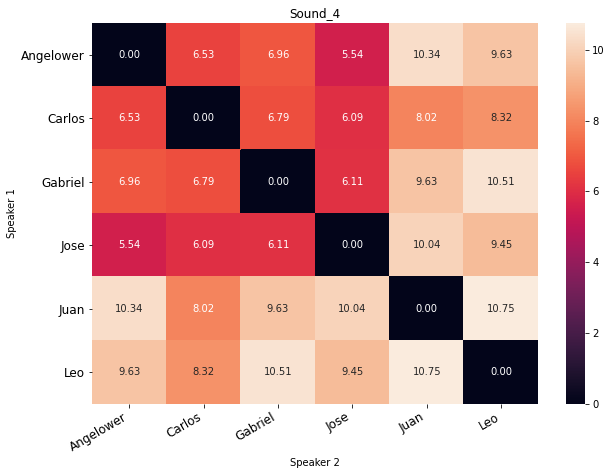

In [0]:
createConfusion_matrix(sound_name='Sound_4')

## Sound_5

In [0]:
#Sound 2
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p225.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p226.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p227.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p228.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p229.hd5
! wget https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p230.hd5


--2020-04-26 02:09:29--  https://github.com/Integrador-VoiceStyleTransfer/Utilities/raw/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p225.hd5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p225.hd5 [following]
--2020-04-26 02:09:29--  https://raw.githubusercontent.com/Integrador-VoiceStyleTransfer/Utilities/master/Similitude/Speaker_Verification/MFCCS_Test/Sound_5/p225.hd5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58368 (57K) [application/octet-stream]
Saving to: ‘p225.hd5’

p225.

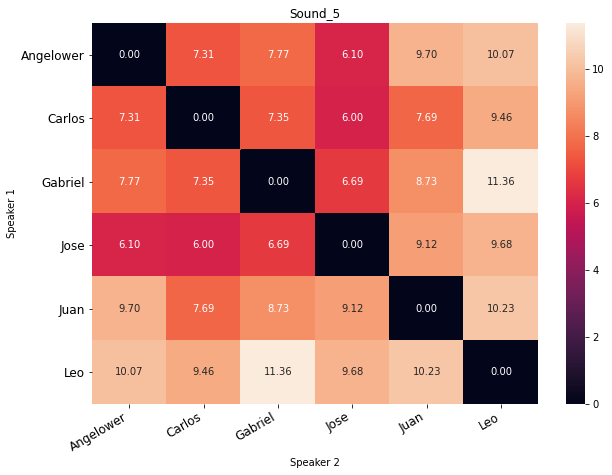

In [0]:
createConfusion_matrix(sound_name='Sound_5')

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=12,sound_name='Sound_1'):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    plt.ylabel('Speaker 1')
    plt.xlabel('Speaker 2')
    plt.title(sound_name)
    #return fig

# Todos los audios

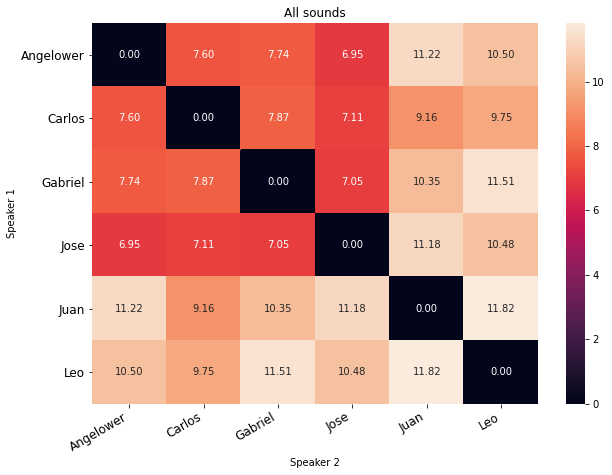

In [23]:
createConfusion_matrix(sound_name='All sounds')